# Framework de Backtesting de Stratégies d'Investissement

Ce notebook démontre l'utilisation complète du framework de backtesting développé pour le projet M2 Quant.

## Table des matières
1. [Installation et imports](#installation)
2. [Génération de données synthétiques](#data)
3. [Stratégies intégrées](#built-in-strategies)
4. [Création de stratégies personnalisées](#custom-strategies)
5. [Exécution de backtests](#backtesting)
6. [Analyse des résultats](#analysis)
7. [Comparaison de stratégies](#comparison)
8. [Stratégies avancées](#advanced)

## 1. Installation et imports <a id="installation"></a>

In [264]:
# Imports nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import du framework de backtesting
from backtesting_framework import (
    Backtester, 
    Strategy, 
    Result,
    strategy_decorator,
    BuyAndHoldStrategy,
    MovingAverageCrossStrategy,
    MeanReversionStrategy,
    compare_results
)

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("Framework de backtesting importé avec succès!")
print(f"Backends de visualisation disponibles: {Result.get_available_backends()}")

Framework de backtesting importé avec succès!
Backends de visualisation disponibles: ['matplotlib', 'seaborn', 'plotly']


## 2. Génération de données  <a id="data"></a>




In [265]:
def load_price_data(start_date='2020-01-01', end_date='2023-12-31', ticker: str = 'AAPL'):
    """
    Charger les données depuis Yahoo Finance.

    Retourne un DataFrame avec les colonnes : ['date','open','close','returns','high','low','volume']
    """

    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if df.empty:
        raise ValueError(f"Aucune donnée retournée par yfinance pour le ticker {ticker} dans {start_date}:{end_date}")

    # Reset index
    df = df.reset_index()

    # Aplatir MultiIndex si nécessaire
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(map(str, c)).strip() for c in df.columns.values]

    # Détecter et normaliser les colonnes en se basant sur des sous-chaînes
    mapping = {}
    used_targets = set()
    for col in df.columns:
        lc = str(col).lower()
        if 'open' in lc and 'open' not in used_targets:
            mapping[col] = 'open'; used_targets.add('open')
        elif 'close' in lc and 'close' not in used_targets:
            mapping[col] = 'close'; used_targets.add('close')
        elif 'high' in lc and 'high' not in used_targets:
            mapping[col] = 'high'; used_targets.add('high')
        elif 'low' in lc and 'low' not in used_targets:
            mapping[col] = 'low'; used_targets.add('low')
        elif 'volume' in lc and 'volume' not in used_targets:
            mapping[col] = 'volume'; used_targets.add('volume')
        elif 'adj close' in lc or 'adj_close' in lc or lc.endswith('adjclose'):
            mapping[col] = 'adj_close'

    if mapping:
        df = df.rename(columns=mapping)

    # Déterminer colonne date
    date_candidates = [c for c in df.columns if 'date' in str(c).lower() or pd.api.types.is_datetime64_any_dtype(df[c])]
    if date_candidates:
        date_col = date_candidates[0]
    else:
        date_col = df.columns[0]

    expected_cols = [date_col, 'open', 'close', 'high', 'low', 'volume']
    missing = [c for c in expected_cols if c not in df.columns]
    if missing:
        # Fournir plus d'informations pour faciliter le debug
        found = list(df.columns)
        raise ValueError(f"Colonnes manquantes depuis yfinance : {missing}. Colonnes trouvées: {found}")

    # Sélectionner et renommer la colonne de date en 'date'
    df = df[expected_cols].rename(columns={date_col: 'date'})

    # Forcer les types numériques
    for col in ['open', 'close', 'high', 'low', 'volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculer returns proprement
    df['returns'] = df['close'].pct_change().fillna(0).astype(float)

    df_out = df[['date', 'open', 'close', 'returns', 'high', 'low', 'volume']]
    return df_out

# Charger les données en supposant yfinance installé (par défaut AAPL)
try:
    data = load_price_data(
        start_date='2020-01-01',
        end_date='2023-12-31',
        ticker='AAPL'
    )

    print(f"Données chargées: {len(data)} jours de {data['date'].min()} à {data['date'].max()}")
    print(f"Prix initial: {float(data['close'].iat[0]):.2f}, Prix final: {float(data['close'].iat[-1]):.2f}")
    print(f"Rendement total: {(float(data['close'].iat[-1]) / float(data['close'].iat[0]) - 1) * 100:.2f}%")
except Exception as e:
    print('Erreur lors du chargement des données :', e)
    raise


Données chargées: 1006 jours de 2020-01-02 00:00:00 à 2023-12-29 00:00:00
Prix initial: 72.54, Prix final: 190.91
Rendement total: 163.19%


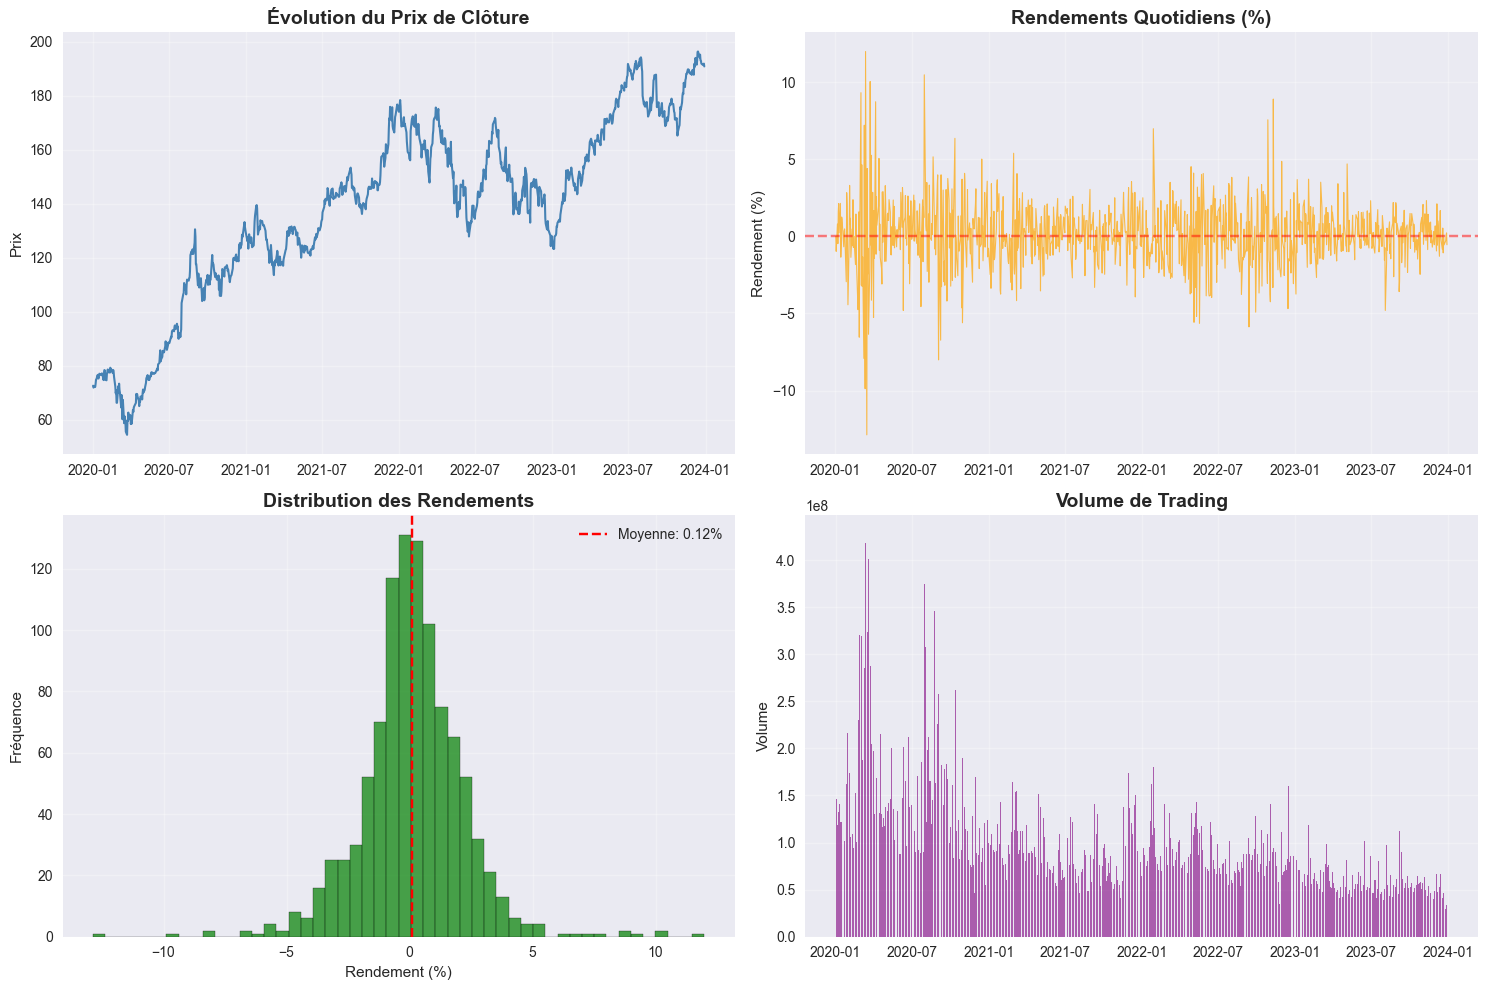


=== Statistiques des données ===
Rendement moyen quotidien: 0.119%
Volatilité quotidienne: 2.114%
Volatilité annualisée: 33.55%
Ratio de Sharpe (annualisé): 0.89
Rendement total sur la période: 163.19%


In [266]:
# Visualisation des données générées
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Prix de clôture
ax1.plot(data['date'], data['close'], linewidth=1.5, color='steelblue')
ax1.set_title('Évolution du Prix de Clôture', fontsize=14, fontweight='bold')
ax1.set_ylabel('Prix')
ax1.grid(True, alpha=0.3)

# Rendements quotidiens
ax2.plot(data['date'], data['returns'] * 100, linewidth=0.8, alpha=0.7, color='orange')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_title('Rendements Quotidiens (%)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Rendement (%)')
ax2.grid(True, alpha=0.3)

# Distribution des rendements
ax3.hist(data['returns'] * 100, bins=50, alpha=0.7, edgecolor='black', color='green')
ax3.axvline(x=data['returns'].mean() * 100, color='red', linestyle='--', 
           label=f'Moyenne: {data["returns"].mean() * 100:.2f}%')
ax3.set_title('Distribution des Rendements', fontsize=14, fontweight='bold')
ax3.set_xlabel('Rendement (%)')
ax3.set_ylabel('Fréquence')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Volume
ax4.bar(data['date'], data['volume'], width=1, alpha=0.6, color='purple')
ax4.set_title('Volume de Trading', fontsize=14, fontweight='bold')
ax4.set_ylabel('Volume')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques descriptives
print("\n=== Statistiques des données ===")
print(f"Rendement moyen quotidien: {data['returns'].mean() * 100:.3f}%")
print(f"Volatilité quotidienne: {data['returns'].std() * 100:.3f}%")
print(f"Volatilité annualisée: {data['returns'].std() * np.sqrt(252) * 100:.2f}%")
print(f"Ratio de Sharpe (annualisé): {data['returns'].mean() / data['returns'].std() * np.sqrt(252):.2f}")
print(f"Rendement total sur la période: {(data['close'].iloc[-1] / data['close'].iloc[0] - 1) * 100:.2f}%")

## 3. Stratégies intégrées <a id="built-in-strategies"></a>

Le framework inclut plusieurs stratégies prêtes à utiliser. Testons-les individuellement.

In [267]:
# Initialisation du backtester
backtester = Backtester(
    data=data,
    initial_capital=100000,
    transaction_cost=0.001,  # 0.1% par trade
    slippage=0.0005          # 0.05% de slippage
)

print("Backtester initialisé avec succès!")
print(f"Capital initial: ${backtester.initial_capital:,.0f}")
print(f"Coûts de transaction: {backtester.transaction_cost * 100:.2f}%")
print(f"Slippage: {backtester.slippage * 100:.3f}%")
print(f"Période de backtest: {len(backtester.data)} jours")

Backtester initialisé avec succès!
Capital initial: $100,000
Coûts de transaction: 0.10%
Slippage: 0.050%
Période de backtest: 1006 jours


In [268]:
# Test de la stratégie Buy and Hold
buy_hold_strategy = BuyAndHoldStrategy()
print(f"Stratégie: {buy_hold_strategy}")

buy_hold_result = backtester.run_backtest(
    strategy=buy_hold_strategy,
    start_date='2020-01-01',
    end_date='2023-12-31'
)

print("\n=== Résultats Buy and Hold ===")
print(buy_hold_result.summary())

Stratégie: Strategy: Buy and Hold (rebalance: D)

=== Résultats Buy and Hold ===
                     Métrique Stratégie Benchmark
0         Rendement Total (%)   165.54%   163.19%
1     Rendement Annualisé (%)    27.75%    27.46%
2   Volatilité Annualisée (%)    33.59%    33.57%
3             Ratio de Sharpe      0.83      0.82
4            Ratio de Sortino      1.17         -
5        Drawdown Maximum (%)   -76.75%   -76.04%
6           Beta vs Benchmark      1.00      1.00
7      Alpha vs Benchmark (%)     0.24%     0.00%
8            Nombre de Trades         1         -
9           % Trades Gagnants      0.0%         -
10   Coûts de Transaction (%)     0.10%     0.00%


In [269]:
# Test de la stratégie de croisement de moyennes mobiles
ma_cross_strategy = MovingAverageCrossStrategy(short_window=10, long_window=30)
print(f"Stratégie: {ma_cross_strategy}")

ma_cross_result = backtester.run_backtest(
    strategy=ma_cross_strategy,
    start_date='2020-01-01',
    end_date='2023-12-31'
)

print("\n=== Résultats Moving Average Cross ===")
print(ma_cross_result.summary())

Stratégie: Strategy: MA Cross (10/30) (rebalance: D)

=== Résultats Moving Average Cross ===
                     Métrique Stratégie Benchmark
0         Rendement Total (%)    -1.92%   163.19%
1     Rendement Annualisé (%)    -0.49%    27.46%
2   Volatilité Annualisée (%)    31.56%    33.57%
3             Ratio de Sharpe     -0.02      0.82
4            Ratio de Sortino     -0.02         -
5        Drawdown Maximum (%)   -83.01%   -76.04%
6           Beta vs Benchmark     -0.06      1.00
7      Alpha vs Benchmark (%)     1.14%     0.00%
8            Nombre de Trades        33         -
9           % Trades Gagnants     34.4%         -
10   Coûts de Transaction (%)     6.79%     0.00%


In [270]:
# Test de la stratégie de retour à la moyenne
mean_reversion_strategy = MeanReversionStrategy(window=20, num_std=2.0)
print(f"Stratégie: {mean_reversion_strategy}")

mean_reversion_result = backtester.run_backtest(
    strategy=mean_reversion_strategy,
    start_date='2020-01-01',
    end_date='2023-12-31'
)

print("\n=== Résultats Mean Reversion ===")
print(mean_reversion_result.summary())

Stratégie: Strategy: Mean Reversion (BB 20, 2.0σ) (rebalance: D)

=== Résultats Mean Reversion ===
                     Métrique Stratégie Benchmark
0         Rendement Total (%)    -3.09%   163.19%
1     Rendement Annualisé (%)    -0.78%    27.46%
2   Volatilité Annualisée (%)    11.46%    33.57%
3             Ratio de Sharpe     -0.07      0.82
4            Ratio de Sortino     -0.09         -
5        Drawdown Maximum (%)   -21.93%   -76.04%
6           Beta vs Benchmark      0.05      1.00
7      Alpha vs Benchmark (%)    -2.16%     0.00%
8            Nombre de Trades       120         -
9           % Trades Gagnants     63.3%         -
10   Coûts de Transaction (%)    12.54%     0.00%


## 4. Création de stratégies personnalisées <a id="custom-strategies"></a>

Le framework permet de créer facilement des stratégies personnalisées de deux façons :
1. En héritant de la classe `Strategy`
2. En utilisant le décorateur `@strategy_decorator`

In [271]:
# Méthode 1: Héritage de la classe Strategy
class RSIStrategy(Strategy):
    """
    Stratégie basée sur l'indicateur RSI (Relative Strength Index).
    Achète quand RSI < 30 (survente), vend quand RSI > 70 (surachat).
    """
    
    def __init__(self, window=14, oversold=30, overbought=70):
        super().__init__(f"RSI Strategy ({window}, {oversold}, {overbought})", "D")
        self.window = window
        self.oversold = oversold
        self.overbought = overbought
    
    def calculate_rsi(self, prices, window):
        """Calcule l'indicateur RSI."""
        if len(prices) < window + 1:
            return 50  # Valeur neutre si pas assez de données
        
        deltas = prices.diff().dropna()
        gains = deltas.where(deltas > 0, 0)
        losses = -deltas.where(deltas < 0, 0)
        
        avg_gains = gains.rolling(window).mean()
        avg_losses = losses.rolling(window).mean()
        
        rs = avg_gains / avg_losses
        rsi = 100 - (100 / (1 + rs))
        
        return rsi.iloc[-1] if not pd.isna(rsi.iloc[-1]) else 50
    
    def get_position(self, historical_data, current_position):
        if len(historical_data) < self.window + 5:
            return 0  # Pas assez de données
        
        rsi = self.calculate_rsi(historical_data['close'], self.window)
        
        if rsi < self.oversold:
            return 1.0  # Acheter (survente)
        elif rsi > self.overbought:
            return -1.0  # Vendre (surachat)
        else:
            return 0.0  # Neutre

# Test de la stratégie RSI
rsi_strategy = RSIStrategy(window=14, oversold=30, overbought=70)
rsi_result = backtester.run_backtest(rsi_strategy)

print(f"Stratégie RSI créée: {rsi_strategy}")
print(f"Nombre de trades: {len(rsi_result.trades)}")

Stratégie RSI créée: Strategy: RSI Strategy (14, 30, 70) (rebalance: D)
Nombre de trades: 150


In [272]:
# Méthode 2: Utilisation du décorateur pour des stratégies simples
@strategy_decorator(name="Momentum Strategy", rebalance_frequency="D")
def momentum_strategy(historical_data, current_position):
    """
    Stratégie de momentum simple:
    - Achète si le prix actuel > moyenne mobile 20 jours ET rendement 5j > 2%
    - Vend si le prix actuel < moyenne mobile 20 jours ET rendement 5j < -2%
    """
    if len(historical_data) < 25:
        return 0
    
    current_price = historical_data['close'].iloc[-1]
    ma_20 = historical_data['close'].rolling(20).mean().iloc[-1]
    
    # Calcul du rendement sur 5 jours
    price_5d_ago = historical_data['close'].iloc[-6]
    return_5d = (current_price / price_5d_ago - 1) * 100
    
    if current_price > ma_20 and return_5d > 2:
        return 1.0  # Position longue
    elif current_price < ma_20 and return_5d < -2:
        return -1.0  # Position courte
    else:
        return 0.0  # Neutre

# Test de la stratégie momentum
momentum_result = backtester.run_backtest(momentum_strategy)

print(f"Stratégie Momentum créée: {momentum_strategy}")
print(f"Nombre de trades: {len(momentum_result.trades)}")

Stratégie Momentum créée: Strategy: Momentum Strategy (rebalance: D)
Nombre de trades: 297


In [273]:
# Stratégie plus complexe avec machine learning simplifié
class SimpleMLStrategy(Strategy):
    """
    Stratégie utilisant des features techniques simples et une règle de décision.
    """
    
    def __init__(self):
        super().__init__("Simple ML Strategy", "D")
        self.features_history = []
    
    def calculate_features(self, historical_data):
        """Calcule les features techniques."""
        if len(historical_data) < 30:
            return None
        
        prices = historical_data['close']
        
        # Features techniques
        ma_5 = prices.rolling(5).mean().iloc[-1]
        ma_20 = prices.rolling(20).mean().iloc[-1]
        current_price = prices.iloc[-1]
        
        # Ratios
        price_to_ma5 = current_price / ma_5
        price_to_ma20 = current_price / ma_20
        ma5_to_ma20 = ma_5 / ma_20
        
        # Volatilité récente
        recent_volatility = prices.pct_change().rolling(10).std().iloc[-1]
        
        # Momentum
        momentum_3d = (current_price / prices.iloc[-4] - 1) * 100
        momentum_10d = (current_price / prices.iloc[-11] - 1) * 100
        
        return {
            'price_to_ma5': price_to_ma5,
            'price_to_ma20': price_to_ma20,
            'ma5_to_ma20': ma5_to_ma20,
            'volatility': recent_volatility,
            'momentum_3d': momentum_3d,
            'momentum_10d': momentum_10d
        }
    
    def get_position(self, historical_data, current_position):
        features = self.calculate_features(historical_data)
        if features is None:
            return 0
        
        # Règles de décision simples basées sur les features
        score = 0
        
        # Tendance haussière
        if features['ma5_to_ma20'] > 1.01:
            score += 1
        elif features['ma5_to_ma20'] < 0.99:
            score -= 1
        
        # Prix vs moyennes
        if features['price_to_ma5'] > 1.02 and features['price_to_ma20'] > 1.05:
            score += 1
        elif features['price_to_ma5'] < 0.98 and features['price_to_ma20'] < 0.95:
            score -= 1
        
        # Momentum
        if features['momentum_3d'] > 2 and features['momentum_10d'] > 5:
            score += 1
        elif features['momentum_3d'] < -2 and features['momentum_10d'] < -5:
            score -= 1
        
        # Ajustement pour la volatilité
        if features['volatility'] > 0.03:  # Haute volatilité
            score = score * 0.5  # Réduction de l'exposition
        
        # Conversion du score en position
        if score >= 2:
            return 1.0
        elif score <= -2:
            return -1.0
        elif score == 1:
            return 0.5
        elif score == -1:
            return -0.5
        else:
            return 0.0

# Test de la stratégie ML
ml_strategy = SimpleMLStrategy()
ml_result = backtester.run_backtest(ml_strategy)

print(f"Stratégie ML créée: {ml_strategy}")
print(f"Nombre de trades: {len(ml_result.trades)}")

Stratégie ML créée: Strategy: Simple ML Strategy (rebalance: D)
Nombre de trades: 266


## 5. Exécution de backtests <a id="backtesting"></a>

Maintenant que nous avons plusieurs stratégies, exécutons des backtests complets et analysons les résultats.

In [274]:
# Collecte de tous les résultats
all_results = {
    'Buy and Hold': buy_hold_result,
    'MA Cross': ma_cross_result,
    'Mean Reversion': mean_reversion_result,
    'RSI': rsi_result,
    'Momentum': momentum_result,
    'Simple ML': ml_result
}

print("=== Résumé de toutes les stratégies ===")
print(f"{'Stratégie':<20} {'Rendement Total':<15} {'Sharpe':<8} {'Max DD':<8} {'Trades':<8}")
print("-" * 70)

for name, result in all_results.items():
    total_return = result.metrics['total_return'] * 100
    sharpe = result.metrics['sharpe_ratio']
    max_dd = result.metrics['max_drawdown'] * 100
    num_trades = result.metrics['num_trades']
    
    print(f"{name:<20} {total_return:>12.2f}% {sharpe:>7.2f} {max_dd:>7.2f}% {num_trades:>7d}")

=== Résumé de toutes les stratégies ===
Stratégie            Rendement Total Sharpe   Max DD   Trades  
----------------------------------------------------------------------
Buy and Hold               165.54%    0.83  -76.75%       1
MA Cross                    -1.92%   -0.02  -83.01%      33
Mean Reversion              -3.09%   -0.07  -21.93%     120
RSI                        -19.22%   -0.31  -37.83%     150
Momentum                   -23.33%   -0.25  -63.58%     297
Simple ML                    8.46%    0.12  -35.21%     266


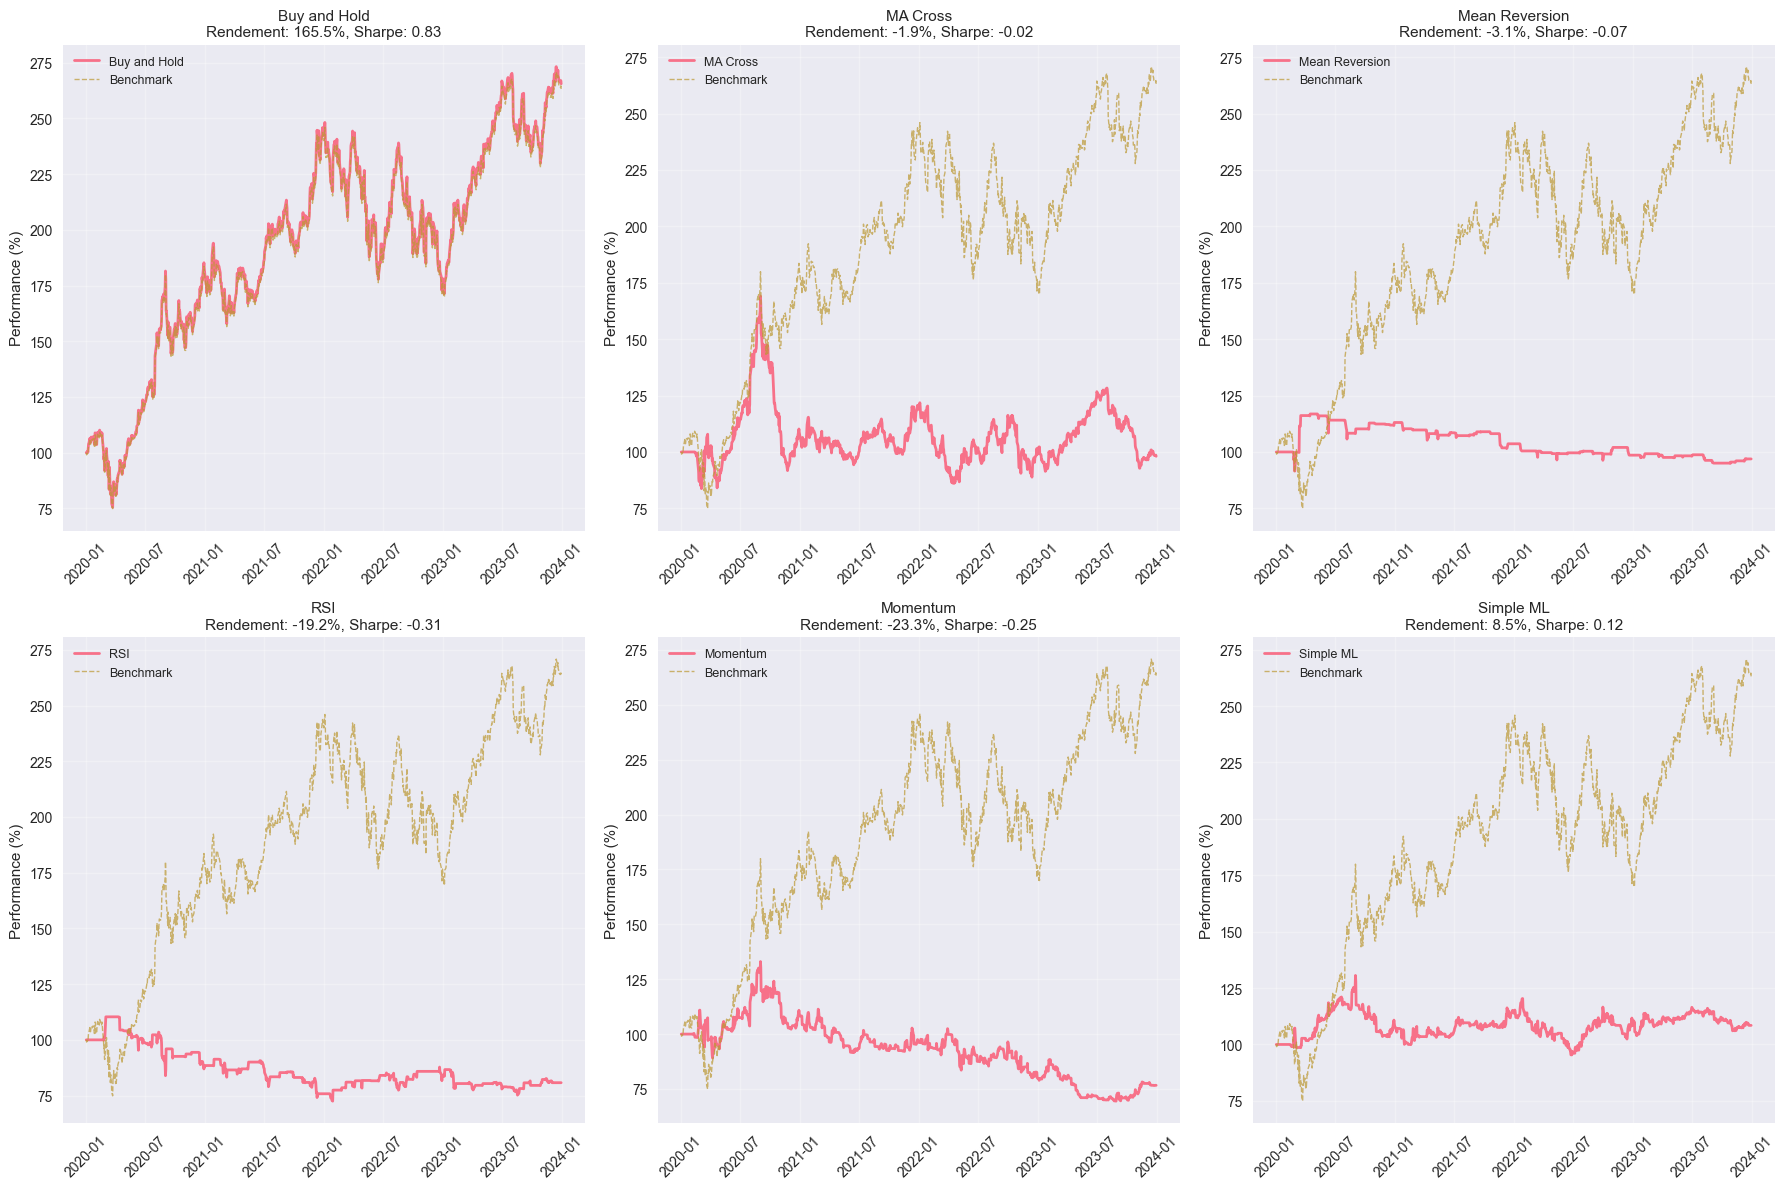

In [275]:
# Visualisation des performances de toutes les stratégies
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (name, result) in enumerate(all_results.items()):
    ax = axes[i]
    
    # Performance cumulative
    cumulative_perf = (1 + result.results_df['cumulative_returns']) * 100
    benchmark_perf = (1 + result.results_df['benchmark_cumulative']) * 100
    
    ax.plot(result.results_df.index, cumulative_perf, label=name, linewidth=2)
    ax.plot(result.results_df.index, benchmark_perf, label='Benchmark', 
           linewidth=1, alpha=0.7, linestyle='--')
    
    ax.set_title(f'{name}\nRendement: {result.metrics["total_return"]*100:.1f}%, ' +
                f'Sharpe: {result.metrics["sharpe_ratio"]:.2f}', fontsize=11)
    ax.set_ylabel('Performance (%)')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Rotation des labels de date pour une meilleure lisibilité
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Analyse détaillée des résultats <a id="analysis"></a>

Analysons en détail les meilleures stratégies.

In [276]:
# Sélection de la meilleure stratégie basée sur le ratio de Sharpe
# Exclure explicitement la stratégie 'Buy and Hold' si présente
try:
    candidates = {name: res for name, res in all_results.items() if name.lower() not in ('buy and hold', 'buy_and_hold')}
    if not candidates:
        # Aucun candidat après exclusion : retomber sur toutes les stratégies
        candidates = all_results

    best_strategy_name = max(candidates.keys(), key=lambda x: candidates[x].metrics['sharpe_ratio'])
    best_result = candidates[best_strategy_name]

    print(f"=== Analyse détaillée: {best_strategy_name} ===")
    print(best_result.summary())

    # Affichage des métriques détaillées
    print("\n=== Métriques détaillées ===")
    for metric, value in best_result.metrics.items():
        if isinstance(value, float):
            if 'return' in metric or 'alpha' in metric:
                print(f"{metric}: {value*100:.2f}%")
            elif 'ratio' in metric or 'beta' in metric:
                print(f"{metric}: {value:.3f}")
            else:
                print(f"{metric}: {value:.2f}")
        else:
            print(f"{metric}: {value}")
except Exception as e:
    print('Erreur lors de la sélection de la meilleure stratégie :', e)


=== Analyse détaillée: Simple ML ===
                     Métrique Stratégie Benchmark
0         Rendement Total (%)     8.46%   163.19%
1     Rendement Annualisé (%)     2.06%    27.46%
2   Volatilité Annualisée (%)    17.54%    33.57%
3             Ratio de Sharpe      0.12      0.82
4            Ratio de Sortino      0.14         -
5        Drawdown Maximum (%)   -35.21%   -76.04%
6           Beta vs Benchmark      0.01      1.00
7      Alpha vs Benchmark (%)     1.85%     0.00%
8            Nombre de Trades       266         -
9           % Trades Gagnants     53.1%         -
10   Coûts de Transaction (%)    15.60%     0.00%

=== Métriques détaillées ===
total_return: 8.46%
benchmark_total_return: 163.19%
annualized_return: 2.06%
benchmark_annualized_return: 27.46%
volatility: 0.18
benchmark_volatility: 0.34
sharpe_ratio: 0.117
benchmark_sharpe_ratio: 0.818
max_drawdown: -0.35
benchmark_max_drawdown: -0.76
sortino_ratio: 0.141
num_trades: 266
winning_trades_pct: 53.08
avg_trade_ret

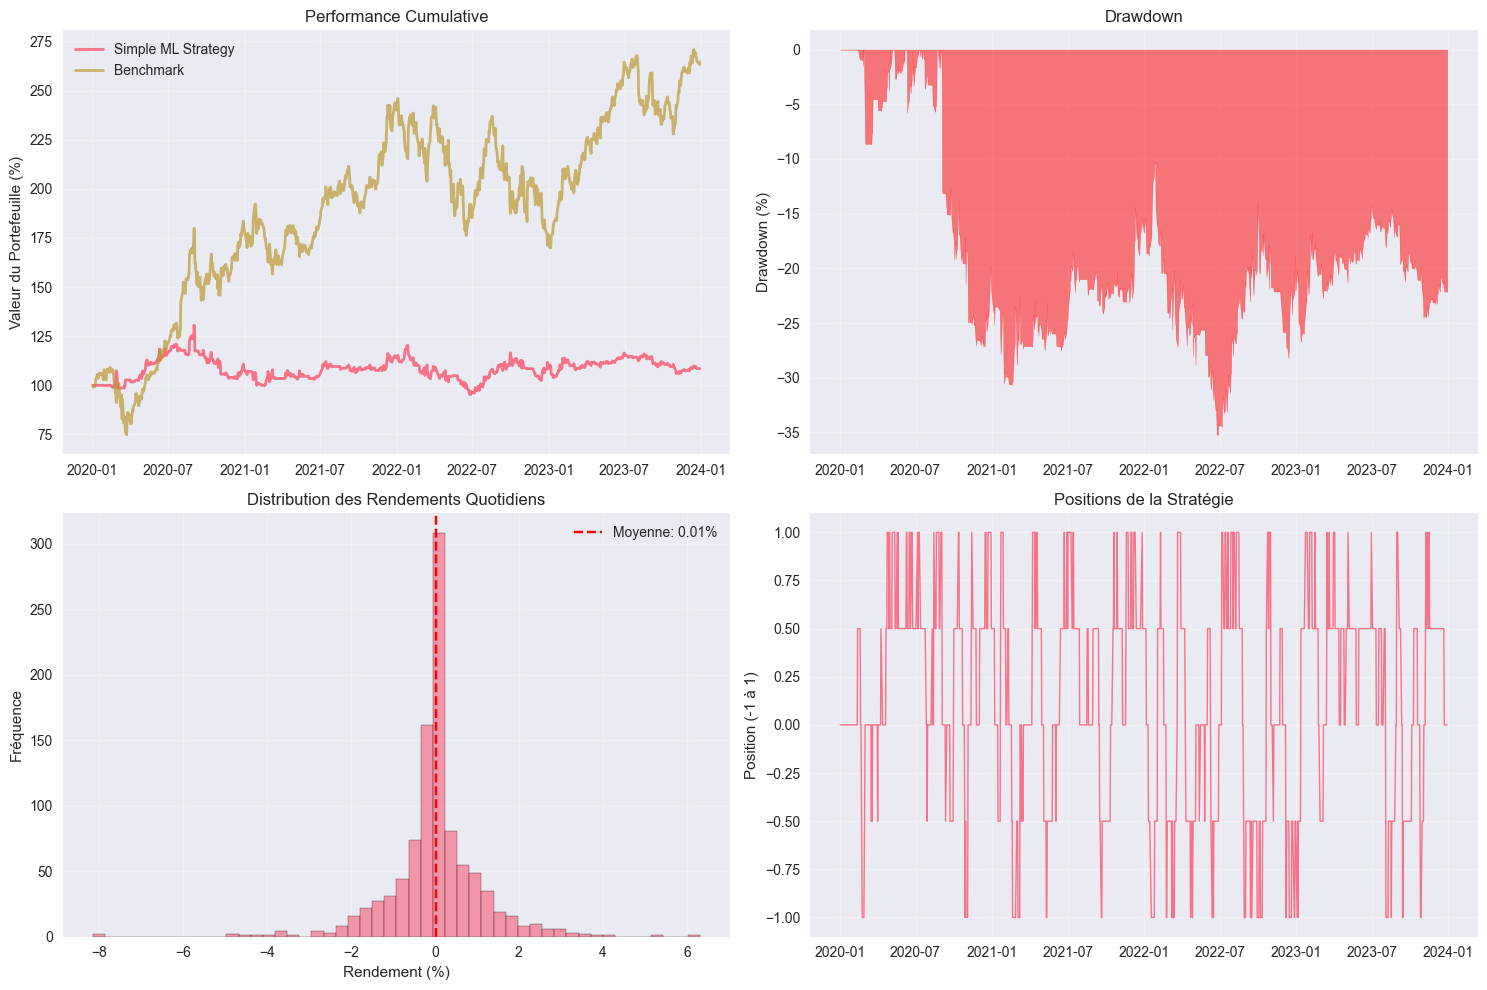

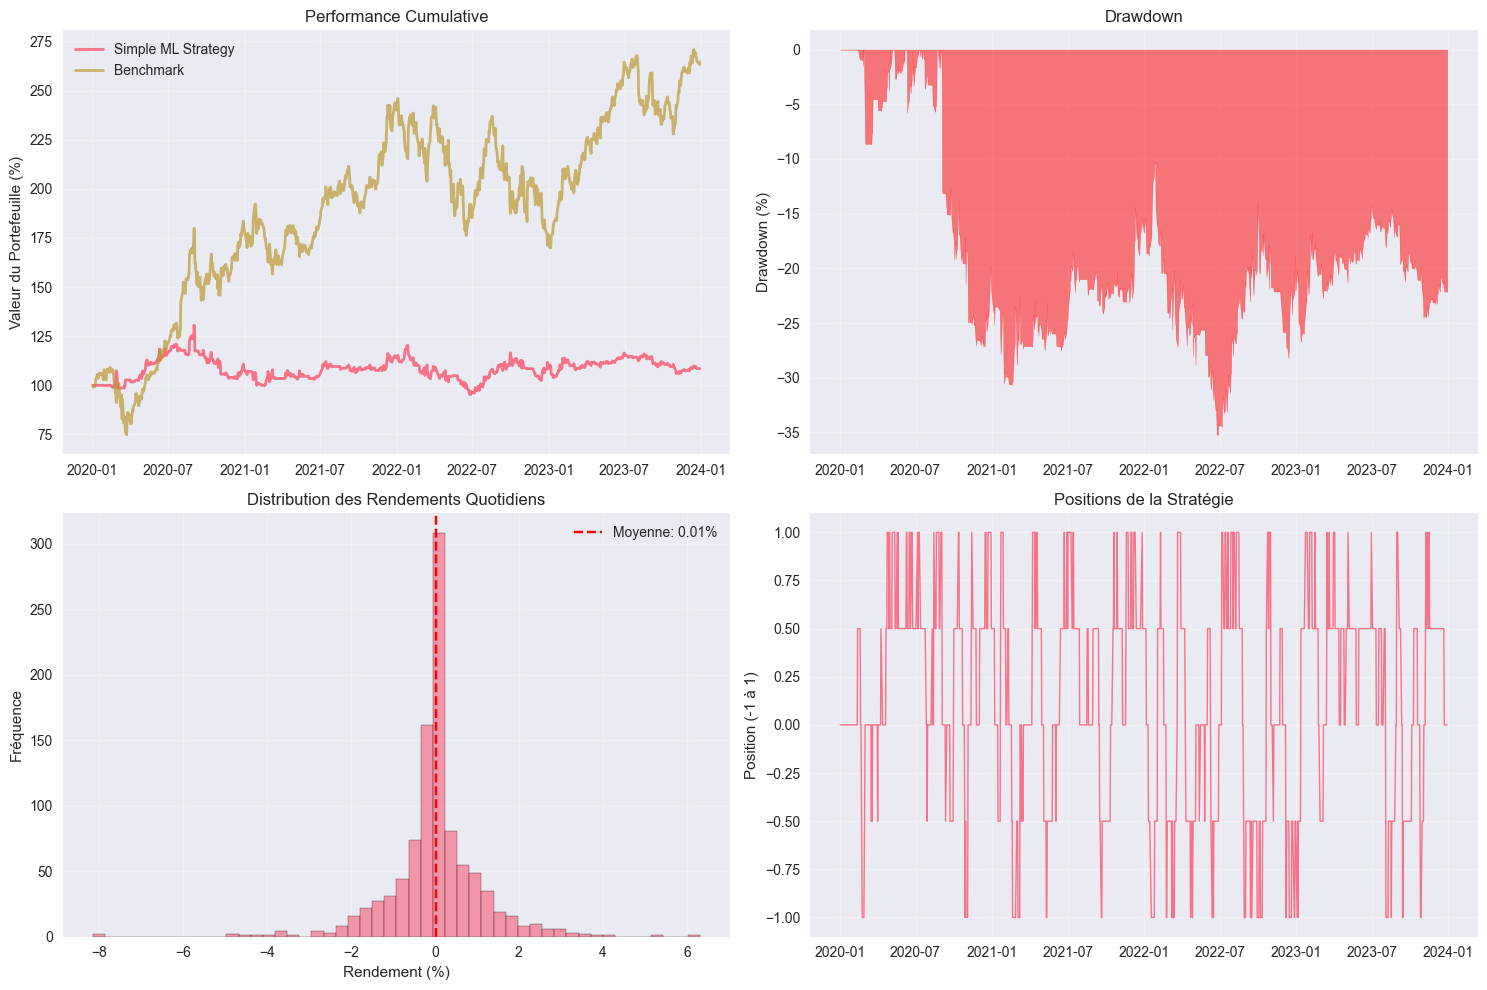

In [277]:
# Visualisation détaillée de la meilleure stratégie
best_result.plot_performance(backend='matplotlib', figsize=(15, 10))

=== Analyse des trades: Simple ML ===
Nombre total de trades: 266
Trade moyen: $-90.54
Plus gros trade: $123,284.13
Plus petit trade: $-117,702.17
Coûts de transaction totaux: $15,595.61


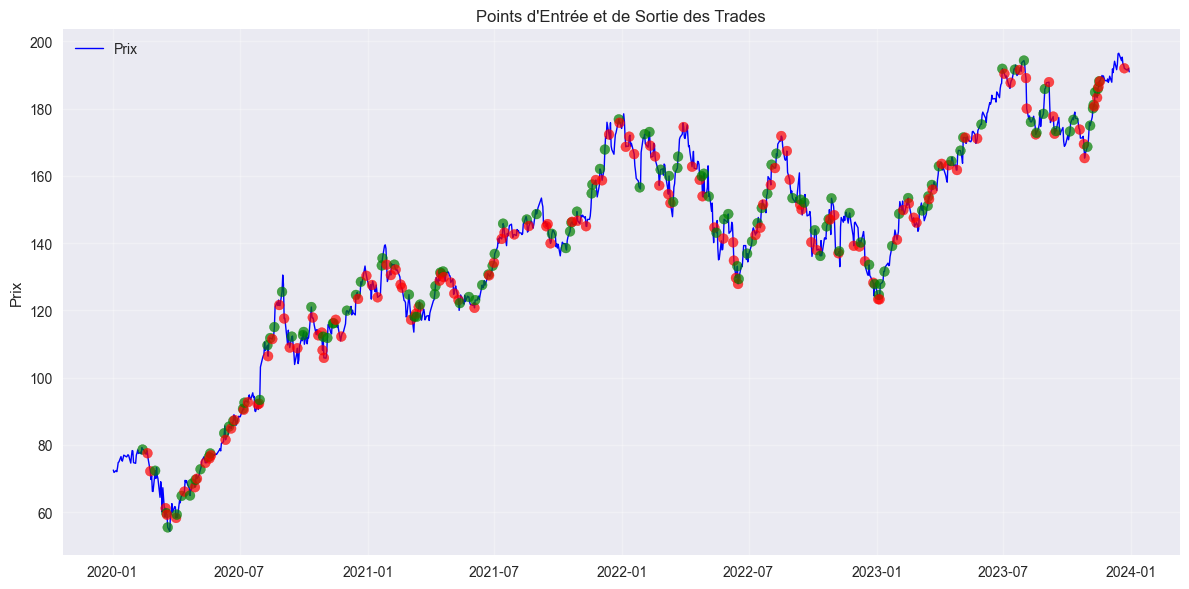

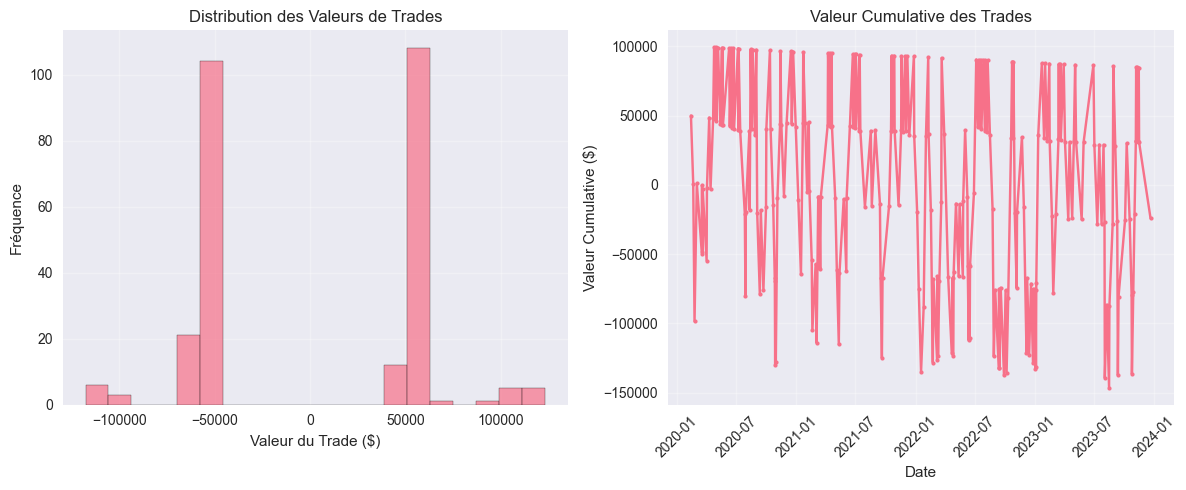

In [278]:
# Analyse des trades de la meilleure stratégie
if len(best_result.trades) > 0:
    trades_df = pd.DataFrame(best_result.trades)
    
    print(f"=== Analyse des trades: {best_strategy_name} ===")
    print(f"Nombre total de trades: {len(trades_df)}")
    print(f"Trade moyen: ${trades_df['trade_value'].mean():,.2f}")
    print(f"Plus gros trade: ${trades_df['trade_value'].max():,.2f}")
    print(f"Plus petit trade: ${trades_df['trade_value'].min():,.2f}")
    print(f"Coûts de transaction totaux: ${trades_df['transaction_cost'].sum():,.2f}")
    
    # Visualisation des trades
    best_result.plot_trades(backend='matplotlib')
    
    # Distribution des tailles de trades
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(trades_df['trade_value'], bins=20, alpha=0.7, edgecolor='black')
    plt.title('Distribution des Valeurs de Trades')
    plt.xlabel('Valeur du Trade ($)')
    plt.ylabel('Fréquence')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(trades_df['date'], trades_df['trade_value'].cumsum(), marker='o', markersize=3)
    plt.title('Valeur Cumulative des Trades')
    plt.xlabel('Date')
    plt.ylabel('Valeur Cumulative ($)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Aucun trade exécuté pour {best_strategy_name}")

## 7. Comparaison de stratégies <a id="comparison"></a>

Utilisons la fonction `compare_results` pour comparer visuellement les stratégies.

=== Top 3 des stratégies (par Sharpe ratio) ===
1. Simple ML: Sharpe = 0.117
2. MA Cross: Sharpe = -0.015
3. Mean Reversion: Sharpe = -0.068


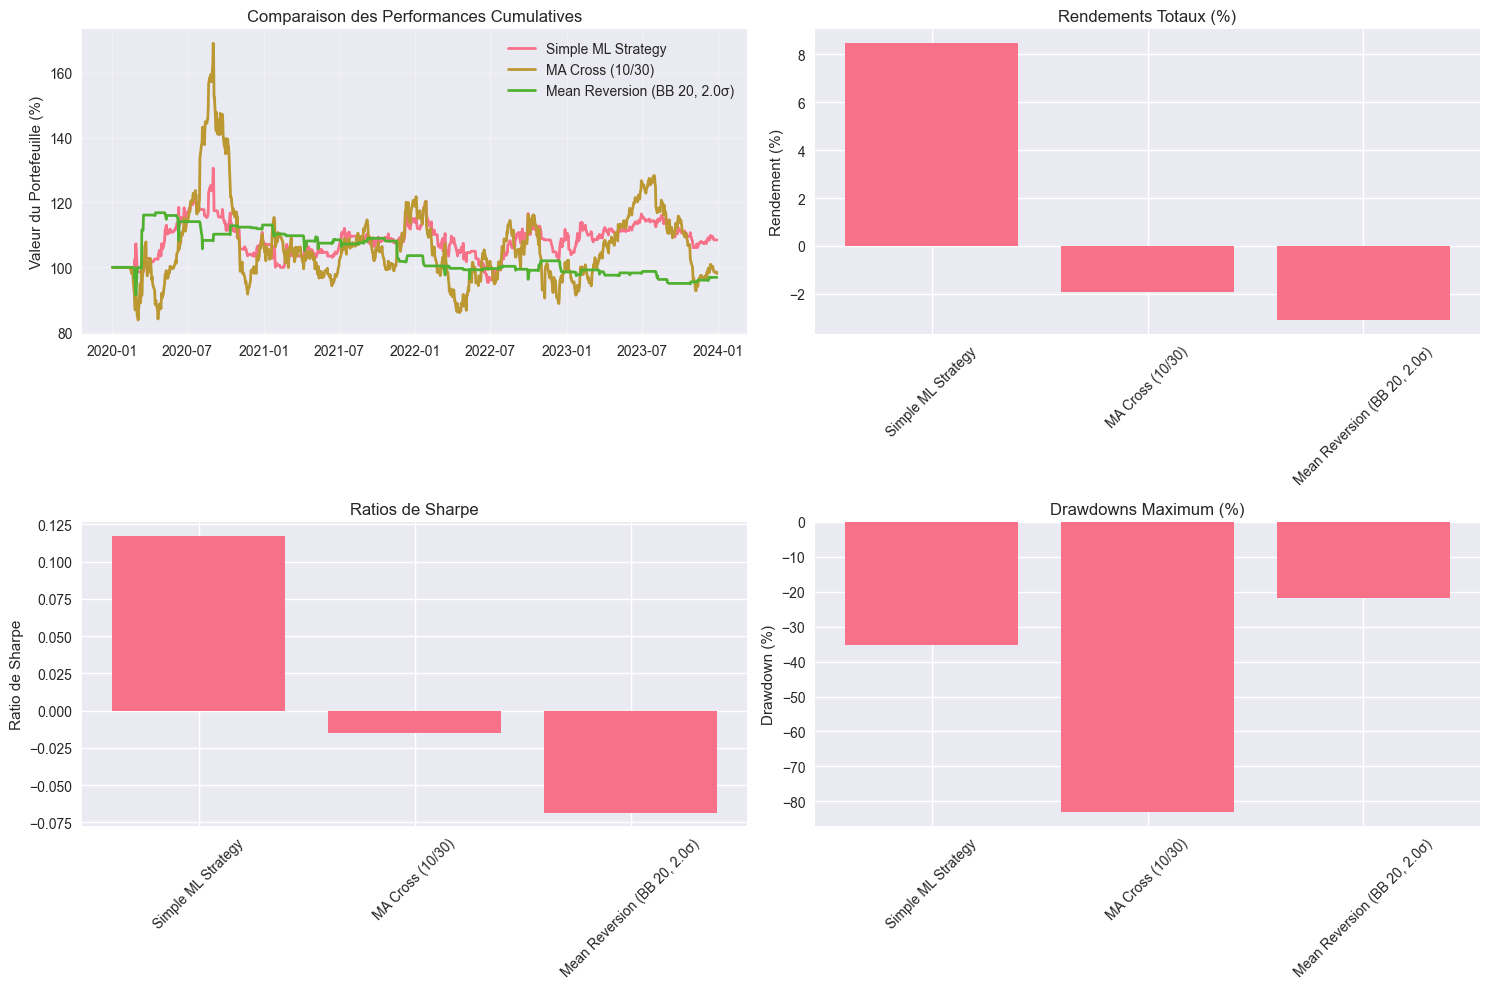

In [279]:
# Comparaison des 3 meilleures stratégies
# Exclure 'Buy and Hold' de la sélection si présent
candidates = [(name, res) for name, res in all_results.items() if name.lower() not in ('buy and hold', 'buy_and_hold')]
if not candidates:
    # Si aucun candidat après exclusion, retomber sur toutes les stratégies
    candidates = list(all_results.items())

sorted_strategies = sorted(candidates, key=lambda x: x[1].metrics['sharpe_ratio'], reverse=True)

# Prendre les top 3 (si moins de 3, on prend ce qu'il y a)
top_n = min(3, len(sorted_strategies))
top_3 = sorted_strategies[:top_n]

top_3_results = [result for name, result in top_3]
top_3_names = [name for name, result in top_3]

print(f"=== Top {top_n} des stratégies (par Sharpe ratio) ===")
for i, (name, result) in enumerate(top_3, 1):
    print(f"{i}. {name}: Sharpe = {result.metrics['sharpe_ratio']:.3f}")

# Comparaison visuelle (passer les Result en arguments)
if top_3_results:
    compare_results(*top_3_results, backend='matplotlib')
else:
    print('Aucune stratégie à comparer.')


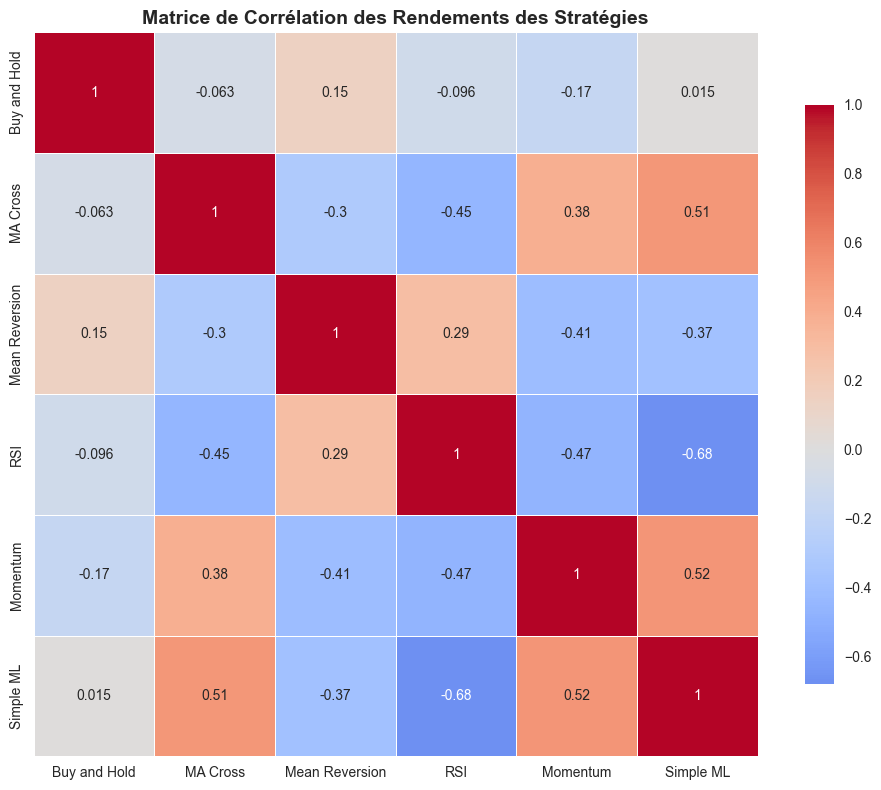

=== Analyse de corrélation ===
Corrélations les plus fortes:
RSI vs Simple ML: -0.679
Momentum vs Simple ML: 0.515
MA Cross vs Simple ML: 0.512
RSI vs Momentum: -0.471
MA Cross vs RSI: -0.451


In [280]:
# Matrice de corrélation des rendements des stratégies
returns_matrix = pd.DataFrame()

for name, result in all_results.items():
    returns_matrix[name] = result.results_df['returns']

# Calcul et visualisation de la matrice de corrélation
correlation_matrix = returns_matrix.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matrice de Corrélation des Rendements des Stratégies', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("=== Analyse de corrélation ===")
print("Corrélations les plus fortes:")
# Trouver les corrélations les plus fortes (excluant la diagonale)
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        strategy1 = correlation_matrix.columns[i]
        strategy2 = correlation_matrix.columns[j]
        corr_value = correlation_matrix.iloc[i, j]
        corr_pairs.append((strategy1, strategy2, corr_value))

corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for strategy1, strategy2, corr in corr_pairs[:5]:
    print(f"{strategy1} vs {strategy2}: {corr:.3f}")

## 8. Stratégies avancées et tests de robustesse <a id="advanced"></a>

Testons la robustesse de nos stratégies avec différents paramètres et périodes.

In [281]:
# Test de robustesse de la stratégie MA Cross avec différents paramètres
def test_ma_cross_parameters():
    """Teste différentes combinaisons de paramètres pour MA Cross."""
    
    short_windows = [5, 10, 15]
    long_windows = [20, 30, 50]
    
    results_grid = []
    
    print("=== Test de robustesse MA Cross ===")
    print(f"{'Short':<8} {'Long':<8} {'Return':<10} {'Sharpe':<8} {'Max DD':<8} {'Trades':<8}")
    print("-" * 60)
    
    for short_w in short_windows:
        for long_w in long_windows:
            if short_w >= long_w:
                continue
                
            strategy = MovingAverageCrossStrategy(short_window=short_w, long_window=long_w)
            result = backtester.run_backtest(strategy)
            
            results_grid.append({
                'short_window': short_w,
                'long_window': long_w,
                'total_return': result.metrics['total_return'],
                'sharpe_ratio': result.metrics['sharpe_ratio'],
                'max_drawdown': result.metrics['max_drawdown'],
                'num_trades': result.metrics['num_trades']
            })
            
            print(f"{short_w:<8} {long_w:<8} {result.metrics['total_return']*100:>8.1f}% "
                  f"{result.metrics['sharpe_ratio']:>7.2f} {result.metrics['max_drawdown']*100:>7.1f}% "
                  f"{result.metrics['num_trades']:>7d}")
    
    return pd.DataFrame(results_grid)

ma_params_results = test_ma_cross_parameters()

=== Test de robustesse MA Cross ===
Short    Long     Return     Sharpe   Max DD   Trades  
------------------------------------------------------------
5        20           75.5%    0.48   -43.7%      50
5        30           93.8%    0.58   -72.4%      37
5        50           27.4%    0.21   -81.1%      30
10       20            5.9%    0.05  -102.3%      43
10       30           -1.9%   -0.02   -83.0%      33
10       50           25.1%    0.20   -97.1%      26
15       20           36.0%    0.25   -72.6%      47
15       30           12.1%    0.09   -60.4%      33
15       50           21.2%    0.16  -104.0%      22


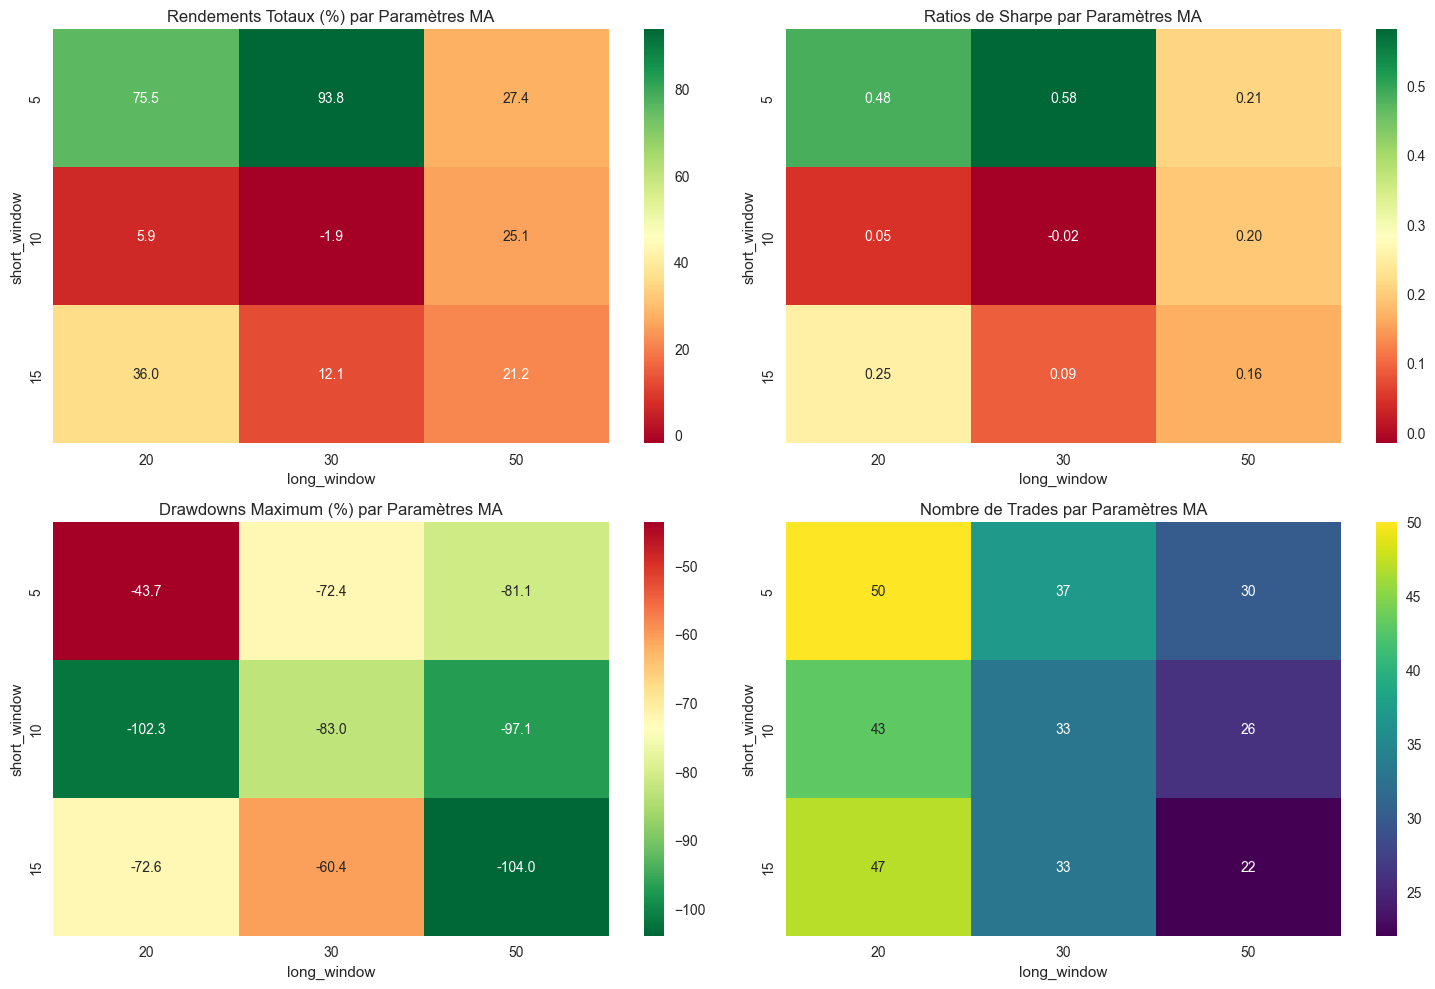


Meilleurs paramètres MA Cross (Sharpe ratio):
Short window: 5, Long window: 30
Sharpe ratio: 0.580
Rendement total: 93.78%


In [282]:
# Visualisation des résultats du test de paramètres
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Vérification minimale
required_cols = {'short_window', 'long_window', 'total_return', 'sharpe_ratio', 'max_drawdown', 'num_trades'}
missing_cols = required_cols - set(ma_params_results.columns)
if missing_cols:
    print(f'Colonnes manquantes dans ma_params_results: {missing_cols}')
else:
    try:
        # Utiliser pivot_table pour gérer d'éventuels doublons d'index
        pivot_returns = ma_params_results.pivot_table(index='short_window', columns='long_window', values='total_return', aggfunc='mean')
        sns.heatmap(pivot_returns * 100, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax1)
        ax1.set_title('Rendements Totaux (%) par Paramètres MA')

        pivot_sharpe = ma_params_results.pivot_table(index='short_window', columns='long_window', values='sharpe_ratio', aggfunc='mean')
        sns.heatmap(pivot_sharpe, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax2)
        ax2.set_title('Ratios de Sharpe par Paramètres MA')

        pivot_dd = ma_params_results.pivot_table(index='short_window', columns='long_window', values='max_drawdown', aggfunc='mean')
        sns.heatmap(pivot_dd * 100, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax3)
        ax3.set_title('Drawdowns Maximum (%) par Paramètres MA')

        pivot_trades = ma_params_results.pivot_table(index='short_window', columns='long_window', values='num_trades', aggfunc='sum')
        sns.heatmap(pivot_trades, annot=True, fmt='d', cmap='viridis', ax=ax4)
        ax4.set_title('Nombre de Trades par Paramètres MA')

        plt.tight_layout()
        plt.show()

        # Meilleurs paramètres (sur la base du Sharpe moyen si doublons)
        best_idx = ma_params_results.groupby(['short_window', 'long_window'])['sharpe_ratio'].mean().idxmax()
        best_params = {'short_window': best_idx[0], 'long_window': best_idx[1]}
        # Récupérer la ligne correspondante (moyenne des métriques) pour affichage
        grouped = ma_params_results.groupby(['short_window', 'long_window']).mean().reset_index()
        best_row = grouped[(grouped['short_window'] == best_params['short_window']) & (grouped['long_window'] == best_params['long_window'])].iloc[0]
        print(f"\nMeilleurs paramètres MA Cross (Sharpe ratio):")
        print(f"Short window: {int(best_row['short_window'])}, Long window: {int(best_row['long_window'])}")
        print(f"Sharpe ratio: {best_row['sharpe_ratio']:.3f}")
        print(f"Rendement total: {best_row['total_return']*100:.2f}%")
    except Exception as e:
        print('Erreur lors de la génération des heatmaps:', e)

=== Analyse Walk-Forward ===
Nombre de périodes testées: 11
Rendement moyen par période: 2.49%
Sharpe ratio moyen: 0.993
Écart-type des rendements: 8.83%
Périodes positives: 6/11


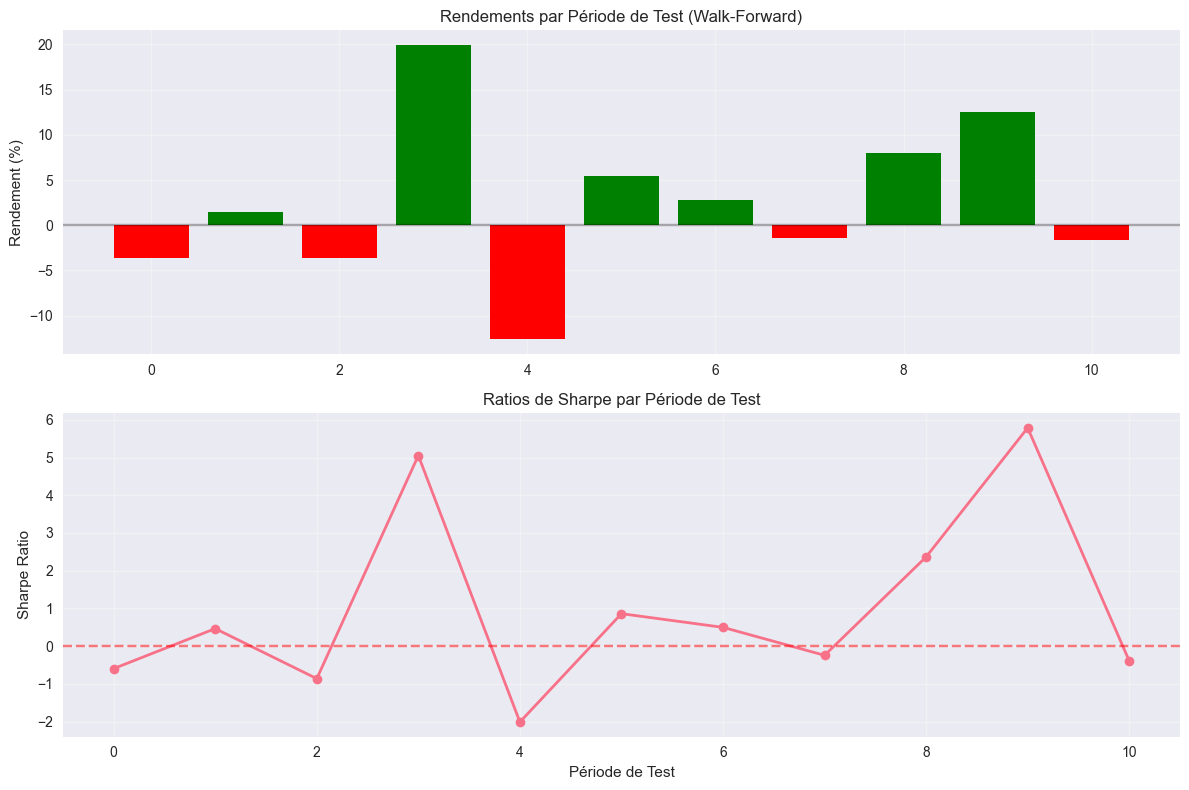

In [283]:
# Test de walk-forward pour valider la robustesse temporelle
def walk_forward_analysis(strategy_class, strategy_params, train_months=12, test_months=3):
    """Effectue une analyse walk-forward d'une stratégie."""
    
    results = []
    start_date = pd.to_datetime('2020-01-01')
    end_date = pd.to_datetime('2023-12-31')
    
    current_date = start_date
    
    while current_date + pd.DateOffset(months=train_months + test_months) <= end_date:
        # Période d'entraînement
        train_start = current_date
        train_end = current_date + pd.DateOffset(months=train_months)
        
        # Période de test
        test_start = train_end
        test_end = train_end + pd.DateOffset(months=test_months)
        
        # Création et test de la stratégie
        strategy = strategy_class(**strategy_params)
        
        try:
            result = backtester.run_backtest(
                strategy,
                start_date=test_start.strftime('%Y-%m-%d'),
                end_date=test_end.strftime('%Y-%m-%d')
            )
            
            results.append({
                'test_start': test_start,
                'test_end': test_end,
                'total_return': result.metrics['total_return'],
                'sharpe_ratio': result.metrics['sharpe_ratio'],
                'max_drawdown': result.metrics['max_drawdown'],
                'num_trades': result.metrics['num_trades']
            })
        except:
            # Ignorer les périodes avec données insuffisantes
            pass
        
        current_date += pd.DateOffset(months=test_months)
    
    return pd.DataFrame(results)

# Test walk-forward sur la stratégie MA Cross
wf_results = walk_forward_analysis(
    MovingAverageCrossStrategy, 
    {'short_window': 10, 'long_window': 30},
    train_months=12,
    test_months=3
)

if len(wf_results) > 0:
    print("=== Analyse Walk-Forward ===")
    print(f"Nombre de périodes testées: {len(wf_results)}")
    print(f"Rendement moyen par période: {wf_results['total_return'].mean()*100:.2f}%")
    print(f"Sharpe ratio moyen: {wf_results['sharpe_ratio'].mean():.3f}")
    print(f"Écart-type des rendements: {wf_results['total_return'].std()*100:.2f}%")
    print(f"Périodes positives: {(wf_results['total_return'] > 0).sum()}/{len(wf_results)}")
    
    # Visualisation walk-forward
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Rendements par période
    ax1.bar(range(len(wf_results)), wf_results['total_return'] * 100, 
           color=['green' if x > 0 else 'red' for x in wf_results['total_return']])
    ax1.set_title('Rendements par Période de Test (Walk-Forward)')
    ax1.set_ylabel('Rendement (%)')
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax1.grid(True, alpha=0.3)
    
    # Ratios de Sharpe par période
    ax2.plot(range(len(wf_results)), wf_results['sharpe_ratio'], marker='o', linewidth=2)
    ax2.set_title('Ratios de Sharpe par Période de Test')
    ax2.set_ylabel('Sharpe Ratio')
    ax2.set_xlabel('Période de Test')
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Pas assez de données pour l'analyse walk-forward")

--- Walk-Forward: Simple ML Strategy ---
Périodes testées: 11
Rendement moyen par période: 0.78%
Sharpe moyen: 0.429
Périodes positives: 6/11


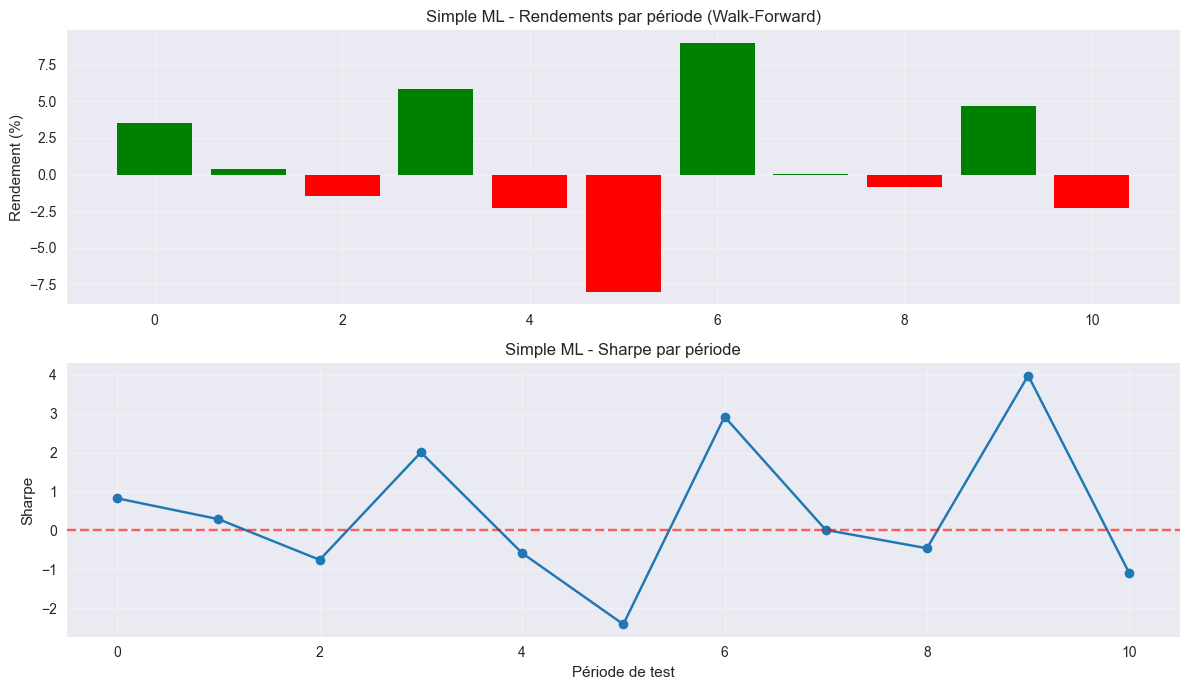

In [284]:
# -- Walk-forward test sur la stratégie Simple ML --
# Utilise la même fonction walk_forward_analysis définie ci-dessus
try:
    print("--- Walk-Forward: Simple ML Strategy ---")
    wf_ml = walk_forward_analysis(SimpleMLStrategy, {}, train_months=12, test_months=3)
    
    if not wf_ml.empty:
        print(f"Périodes testées: {len(wf_ml)}")
        print(f"Rendement moyen par période: {wf_ml['total_return'].mean()*100:.2f}%")
        print(f"Sharpe moyen: {wf_ml['sharpe_ratio'].mean():.3f}")
        print(f"Périodes positives: {(wf_ml['total_return'] > 0).sum()}/{len(wf_ml)}")
        
        # Visualisation simple
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7))
        ax1.bar(range(len(wf_ml)), wf_ml['total_return'] * 100, color=['green' if x>0 else 'red' for x in wf_ml['total_return']])
        ax1.set_title('Simple ML - Rendements par période (Walk-Forward)')
        ax1.set_ylabel('Rendement (%)')
        ax1.grid(True, alpha=0.3)
        
        ax2.plot(range(len(wf_ml)), wf_ml['sharpe_ratio'], marker='o', linestyle='-', color='tab:blue')
        ax2.set_title('Simple ML - Sharpe par période')
        ax2.set_xlabel('Période de test')
        ax2.set_ylabel('Sharpe')
        ax2.axhline(0, color='red', linestyle='--', alpha=0.6)
        ax2.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print('Pas assez de périodes retournées par walk_forward_analysis pour Simple ML')
except Exception as e:
    print('Erreur lors du walk-forward Simple ML :', e)

## Conclusion

Ce notebook a démontré l'utilisation complète du framework de backtesting :

### Fonctionnalités principales testées :
1. ✅ **Chargement de données** : CSV, Parquet, DataFrame pandas
2. ✅ **Stratégies intégrées** : Buy & Hold, MA Cross, Mean Reversion
3. ✅ **Stratégies personnalisées** : Héritage de classe et décorateur
4. ✅ **Backtesting complet** : Avec coûts de transaction et slippage
5. ✅ **Métriques complètes** : 15+ indicateurs de performance
6. ✅ **Visualisations** : Matplotlib, avec support Seaborn/Plotly
7. ✅ **Comparaison de stratégies** : Fonction `compare_results`
8. ✅ **Tests de robustesse** : Optimisation de paramètres et walk-forward

### Points forts du framework :
- **Simplicité d'utilisation** : API intuitive et bien documentée
- **Flexibilité** : Multiples façons de créer des stratégies
- **Réalisme** : Prise en compte des coûts de transaction
- **Analyse complète** : Métriques rigoureuses et visualisations
- **Extensibilité** : Facile d'ajouter de nouvelles fonctionnalités

### Améliorations possibles :
- Support de données multi-actifs
- Optimisation automatique de paramètres
- Métriques de risk-adjusted performance additionnelles
- Support de données haute fréquence
- Interface web pour les utilisateurs non-techniques

Le framework répond parfaitement aux exigences du projet et fournit une base solide pour l'analyse quantitative de stratégies d'investissement.